# Mean heart dose

This notebook demonstrates use of scikit-rt in automatically defining ROIs relevant to constructing a dose plane, and estimating mean heart dose, for a test patient, for whom only a CT image would be available.  The approach here uses data from a set of atlas patients, inncluding, in each case, a CT image, carefully checked ROI outlines, and a dose field.

The idea is as follows:
- register one or more atlas patients to the test patient, performing a rigid registration followed by a deformable registration;
- for each atlas patient considered, use the transform from the deformable registration to map ROI outlines to the frame of reference of the test patient;
- create a outline of the surface of the test patient through intensity-based segmentation;
- operate on the ROIs obtained for the test patient, to create derived ROIs;
- write all ROIs in DICOM format, for further processing.

## Module import and setup

The following imports modules needed for this example, defines the input and output folders, defines the location(s) of registration software, and specifies the test patient.  All patient datasets are assumed to be in the input folder.  Datasets for all patients except the the dataset of test patient are used as atlases.

In [1]:
from pathlib import Path

from skrt import Defaults, Image, Patient, StructureSet
from skrt.core import make_dir, tic, toc, PathData
from skrt.registration import get_engines, get_parameters
from skrt.segmentation import MultiAtlasSegmentation

# Set paths to directories containing registration software.
engine_dirs = {
    "elastix": "/opt/elastix-5.1.0",
    "niftyreg": "/opt/NiftyReg",
}

# Set paths for MATLAB image registration, based on value of matlabreg:
# - True: use matlabreg executable, with MATLAB runtime environment;
# - False: use mskrt package, with MATLAB executable;
# - any other value: "matlab" registration engine not available.
matlabreg = None
if matlabreg is True:
    engine_dirs["matlab"] = "/opt/matlabreg.app/Contents/MacOS"
    Defaults().matlab_runtime = "/Applications/MATLAB/MATLAB_Runtime/R2023a"
elif matlabreg is False:
    engine_dirs["matlab"] = "/opt/matlab-skrt"
    Defaults().matlab_app = "/Applications/MATLAB_R2023a.app/bin"
        
engines = get_engines(engine_dirs, verbose=True)

# Set path to directory to be used for registration output.
outdir = "registration_results/synthetic"

# Ensure that directory for DICOM export exists.
exportdir = make_dir("export", overwrite=False)

# Define local data directory.
datadir = Path("~/data/mean_heart_dose").expanduser()
test_id = "ANON02"
    
# Obtain sorted list of paths to patient folders.
atlas_paths = sorted(path for path in datadir.glob("A*") if test_id != path.name)
test_path = datadir / test_id

# In place of interactive images, display static graphics that can be saved with notebook.
# Defaults().no_ui = True
# Omit user part of paths when printing object attributes.
# Defaults().compress_user = True

Available registration engines: ['elastix', 'niftyreg']


## Data container

The following defines a class that acts as container for the subset of a patient's data relevant to this analysis.  Using this class, rather than the standard `Patient` class reduces the amount of memory needed, while making the data needed easy to access.

In [2]:
class MiniPatient(PathData):
    """
    Container class for a subset of a patient's data.
    """
    
    def __init__(self, path=None, roi_names=None, voxel_size=None, decimal_places=6,
                 verbose=True):
        """
        Constructor for MiniPatient class.
        
        The patient data is required to contain a single CT image, which must have
        associated with it the specified data.  This constructor then aims to extract
        the following:
        
        1. identifier;
        2. sex;
        3. CT image, with the requirement that the patient data should inclue
           only one CT image;
        4. structure set relating to CT image;
        5. radiotherapy plan relating to CT image;
        6. dose relating to radiotherapy plan;
        6. the mean heart dose to each reqeusted ROI.
        
        For a given patient, some of these data may be missing.
        
        **Parameters:**
        path: str or pathlib.Path, default=None
            Path to folder containing a patient dataset.
            
        roi_names: dict, default=None
            Dictionary where keys are the names to be assigned to ROIs for which data
            are to be retained, and values are lists of possible names with which the ROIs
            may be labelled in a structure set.  If None, all ROIs in the original structure
            set are retained.
            
        voxel_size: 3-element list or tuple, default=None
            Voxel (x, y, z) dimensions in mm to be used for resampling imaging data.  If any
            dimension is None, its original value is kept.  If <voxel_size> is None, no
            resampling is performed.  A larger voxel size can be useful for reducing
            the amount of memory needed.
            
        decimal_places: int, default=6
            Number of decimal places with which mean dose values are to be stored.
                    
        verbose: bool, default=True
            If True, print out time for data loading.
        """
        
        # Create Patient object, and initialise attributes of MiniPatient instance.
        if verbose:
            tic()
        super().__init__()
        patient = Patient(path, unsorted_dicom=True)
        self.id = patient.id
        self.sex = patient.get_sex()
        self.structure_set = None
        self.ct = None
        self.plan = None
        self.dose = None
        
        # Identify CT images with required data associations.
        associations=["structure_sets", "plans", "doses"]
        ct_images = patient.get_images("ct", associations=associations)
        assert 1 == len(ct_images)
        self.ct = ct_images[0]
        
        # Extract data associated with CT image.
        for association in associations:
            values = getattr(self.ct, association, [])
            assert 1 == len(values)
            setattr(self, association[:-1], values[0])
                            
        # Optionally filter structure set.
        if isinstance(roi_names, dict):
            self.structure_set.names = roi_names
            self.structure_set.keep_renamed_only=True
            sset_roi_names = self.structure_set.get_roi_names()
            print(sorted(sset_roi_names))
            assert len(roi_names) == len(sset_roi_names)
            assert all(roi_name in sset_roi_names for roi_name in roi_names)
            
        # Resample image.
        if voxel_size is not None:
            self.ct.resize(voxel_size=voxel_size)

        # Crop image to patient region plus border in mm.
        #self.ct.crop(*self.ct.get_foreground_bbox(100))

        # Ensuring that sizes of dose field and ROI masks match size of CT image.
        self.dose.match_size(self.ct)
        self.structure_set.set_image(self.ct)
        
        # Calculate mean doses to requested ROIs.
        self.mean_doses = {roi_name: round(self.dose.get_mean_dose(
            self.structure_set[roi_name]), decimal_places) for roi_name in roi_names}

        if verbose:
            toc(f"{patient.id} - time for data loading: ", ".2f");

        # Free up space in memory of Patient object.
        del patient 

## Data selection

The following selects data for the current analysis.

In [3]:
# Create dictionary of mappings between preferred ROI names (keys)
# and name(s) with which ROIs may be labelled (values).
# Here, ROIs are consistently labelled, so key and value are the same
# in each key-value pair.
# roi_names = ["CTVn_IMN", "CTVp_4000", "Contra_Breast", "Heart", "Ipsi_Lung", "Skin"]
roi_names = ["CTVn_IMN", "CTVp_4000", "Contra_Breast", "Contra_Lung",
             "Heart", "Ipsi_Lung", "PTV_IMN_DVH"]
roi_names = {roi_name: roi_name for roi_name in roi_names}

# Set voxel size (mm) for data loading.
# Where a value is None, the original size is retained.
voxel_size = (3, 3, 6)

# Load data.
print("Loading atlases:")
atlases = [MiniPatient(path, roi_names=roi_names, voxel_size=voxel_size)
           for path in atlas_paths[0:1]]
print("\nLoading test:")
test = MiniPatient(test_path, roi_names=roi_names, voxel_size=voxel_size)

Loading atlases:
['CTVn_IMN', 'CTVp_4000', 'Contra_Breast', 'Contra_Lung', 'Heart', 'Ipsi_Lung', 'PTV_IMN_DVH']
ANON01 - time for data loading: 10.22 seconds

Loading test:
['CTVn_IMN', 'CTVp_4000', 'Contra_Breast', 'Contra_Lung', 'Heart', 'Ipsi_Lung', 'PTV_IMN_DVH']
ANON02 - time for data loading: 15.35 seconds


## Perform multi-atlas segmentation

The following initiates and runs a multi-atlas segmentation.

In [4]:
# Define engine-specific parameters.

# Parameters for global registration.
pfiles1 = {
    "elastix": {
        "translation": get_parameters("*Translation*", "elastix"),
    },
    "matlab":
    {
        "translation": {"exe": "imregtform", "translation": "", "interp": "nearest"},
    },
    "niftyreg": {
        "rigid": get_parameters("*Rigid*", "niftyreg"),
    },
}

# Parameters for local registration.
pfiles2 = {
    "elastix": {
        "bspline": get_parameters("*BSpline15*", "elastix"),
    },
    "matlab":
    {
        "deform": {"exe": "imregdeform"},
    },
    "niftyreg": {
        "bspline": get_parameters("*BSpline05*", "niftyreg"),
    },
}

# Define intensity bands: set intensities of 80 and lower to -1024.
bands = {-1024:(None, 80)}

# Define voxel size (mm) for global registration.
voxel_size1 = None

# Define voxel size (mm) for local registration.
voxel_size2 = None

# Define margins (mm) for cropping to ROIs in local registration.
default_roi_crop_margins = (50, 60, 50)
roi_crop_margins = {"Heart": (50, 60, 50)}


# Set the registration engine.
engine = "elastix"
# engine = "niftyreg"

tic()

# Initialise and run the multi-atlas segmentation.
mas = MultiAtlasSegmentation(
    im1=test.ct, # Set image to be segmented.
    im2={patient.id: patient.ct for patient in atlases}, # Set atlas images.
    engine_dir = engine_dirs[engine], # Set path to registration software.
    workdir=Path(f"results/{test.id}"), # Set path to patient-specific results.
    roi_names=roi_names, # Set ROIs to be segmented.
    initial_alignment="_top_", # Define initial alignment of target and reference images.
    pfiles1=pfiles1[engine], # Define parameters for global registration.
    bands1=bands, # Define intensity bands for global registration.
    voxel_size1=voxel_size1, # Set voxel size for global registration.
    pfiles2=pfiles2[engine], # Define parameters for local registration.
    default_roi_crop_margins=default_roi_crop_margins, # Define default margins for cropping to ROIs in local registration.
    roi_crop_margins=roi_crop_margins, # Define margins for cropping to specified ROI(s) in local registration.
    voxel_size2=voxel_size2, # Set voxel size for local registration.    auto=True, # Run segmentation immediately following initialisation.
    auto_step="local", # Only run the global registrations, so that transform to be applied to dose.
    auto=True, # Run segmentation immediately following initialisation.
    default_strategy="pull", # Pull ROI masks from reference images for segmentation.
    overwrite=True, # Overwrite any previous output.
    capture_output=True, # Suppress registration output, which tends to be quite verbosed.
    log_level="WARNING", # Suppress most messages.
)

toc("Time for segmentation: ", ".2f");

Time for segmentation: 131.85 seconds


## Registration results

The following compare the target image and one of the transformed reference images after each step of the registration. 

ANON02 vs ANON01
elastix: global - initial_alignment


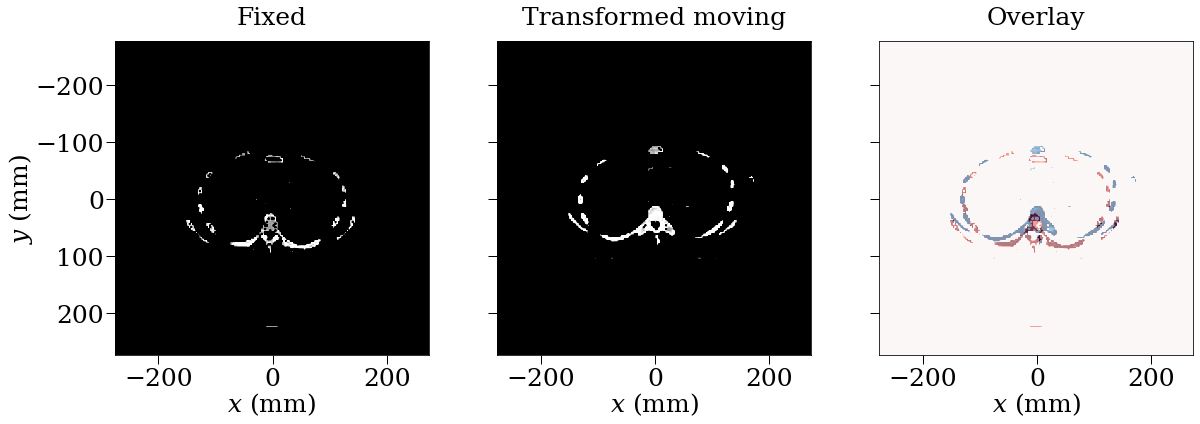

elastix: global - translation


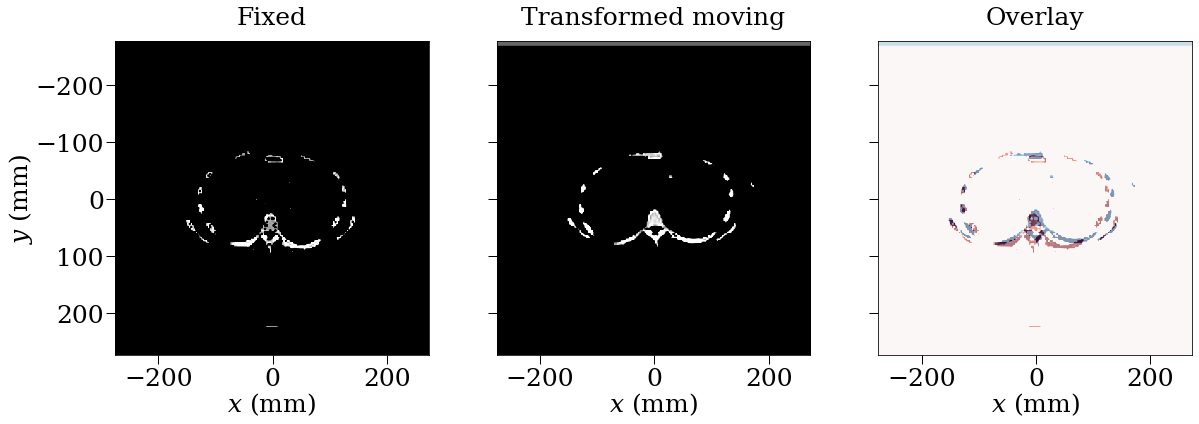

elastix: local (CTVn_IMN) - initial_alignment


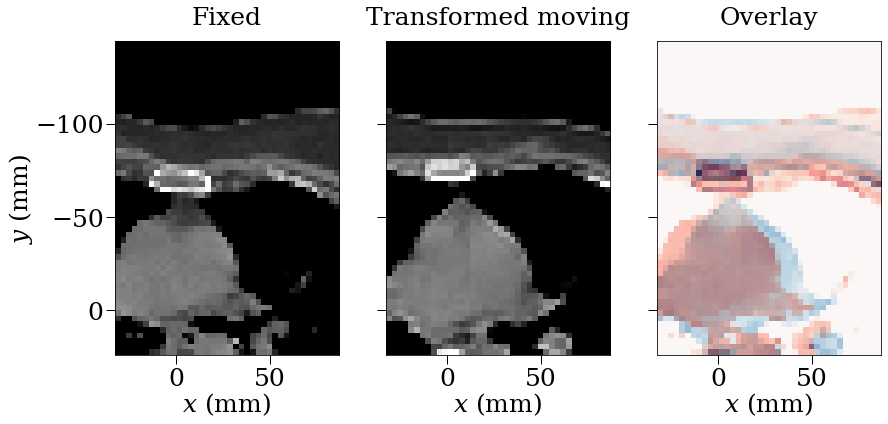

elastix: local (CTVn_IMN) - bspline


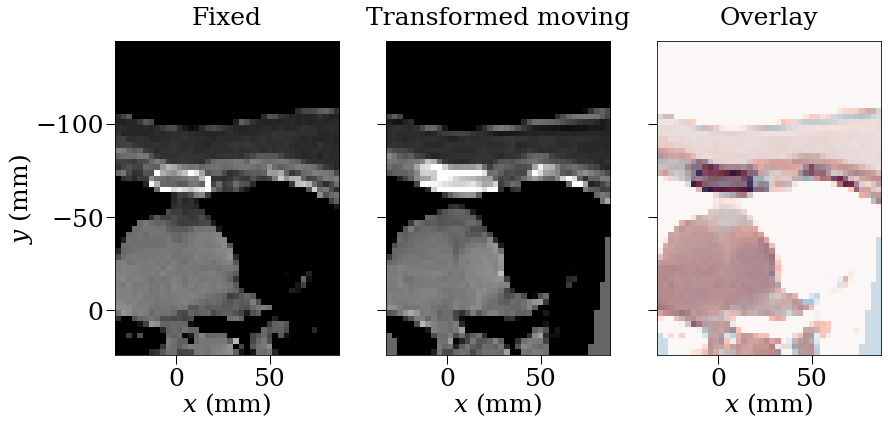

elastix: local (CTVp_4000) - initial_alignment


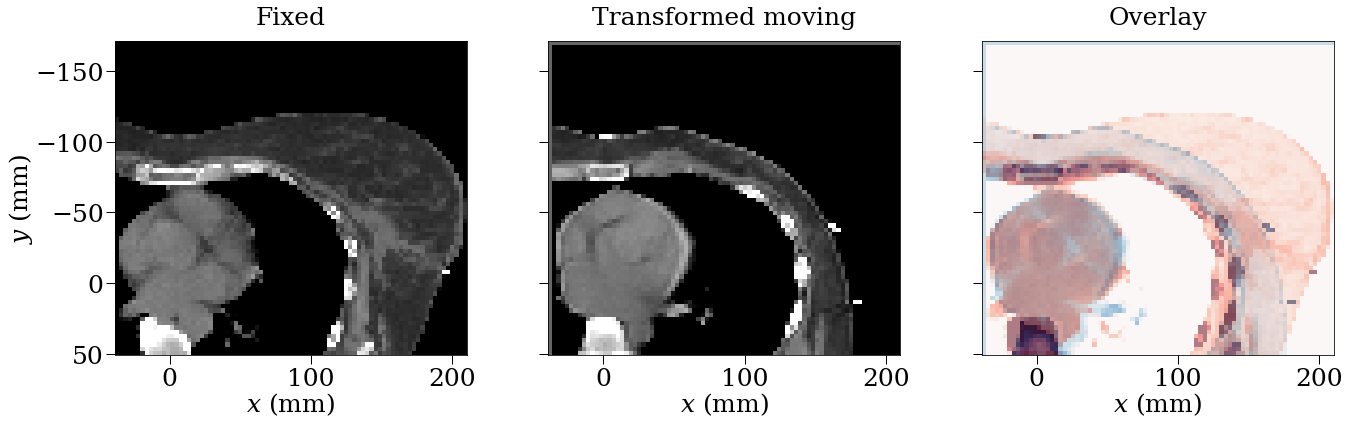

elastix: local (CTVp_4000) - bspline


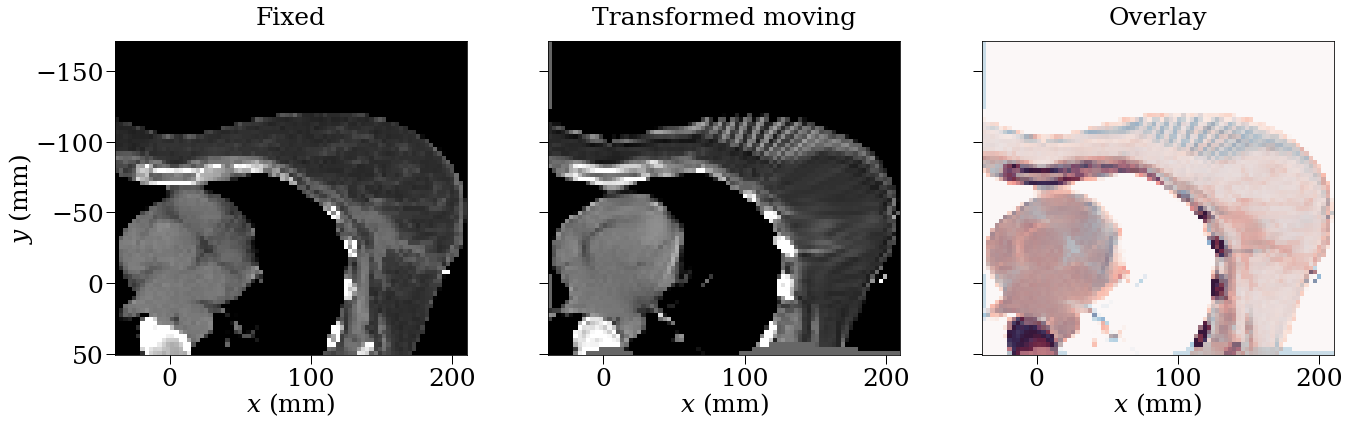

elastix: local (Contra_Breast) - initial_alignment


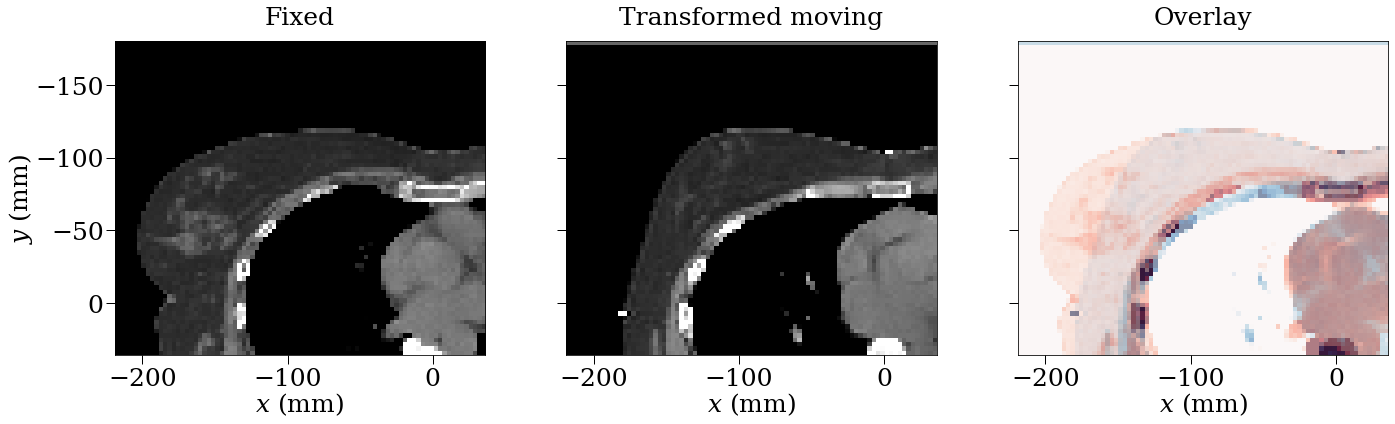

elastix: local (Contra_Breast) - bspline


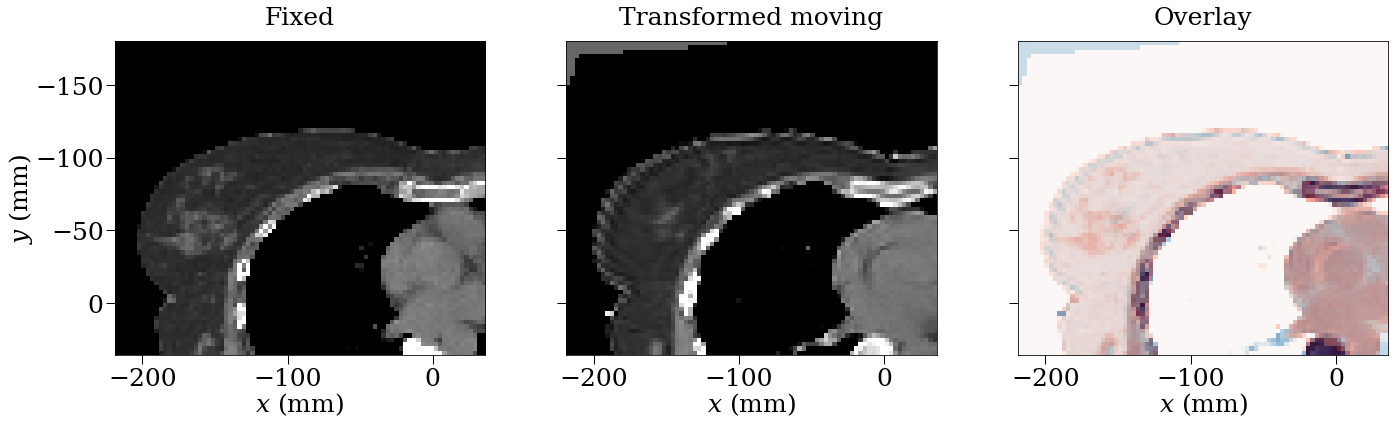

elastix: local (Contra_Lung) - initial_alignment


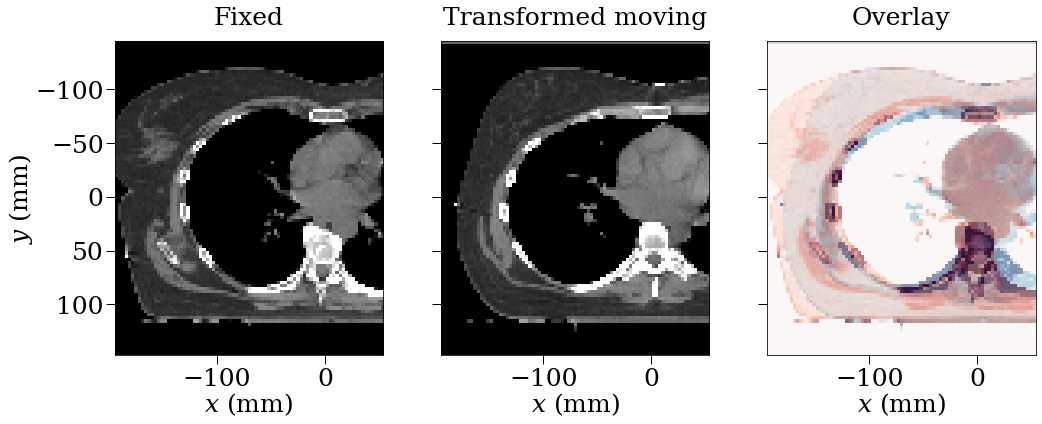

elastix: local (Contra_Lung) - bspline


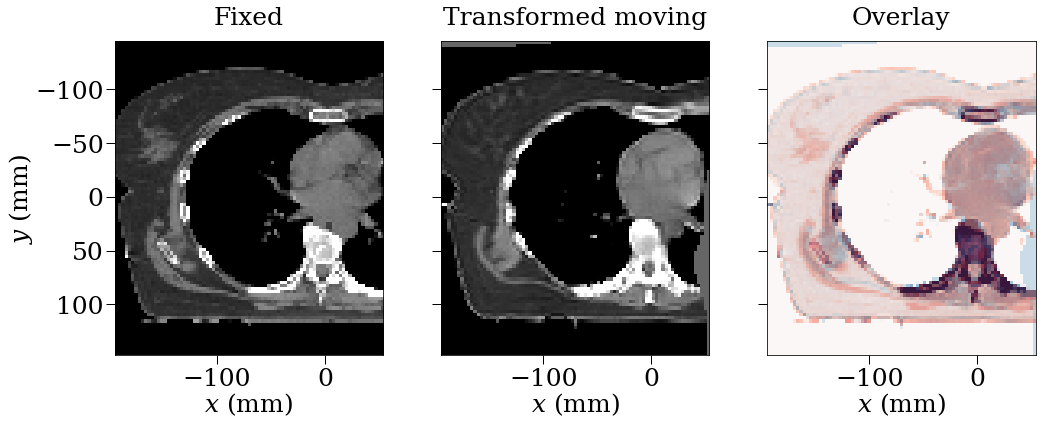

elastix: local (Heart) - initial_alignment


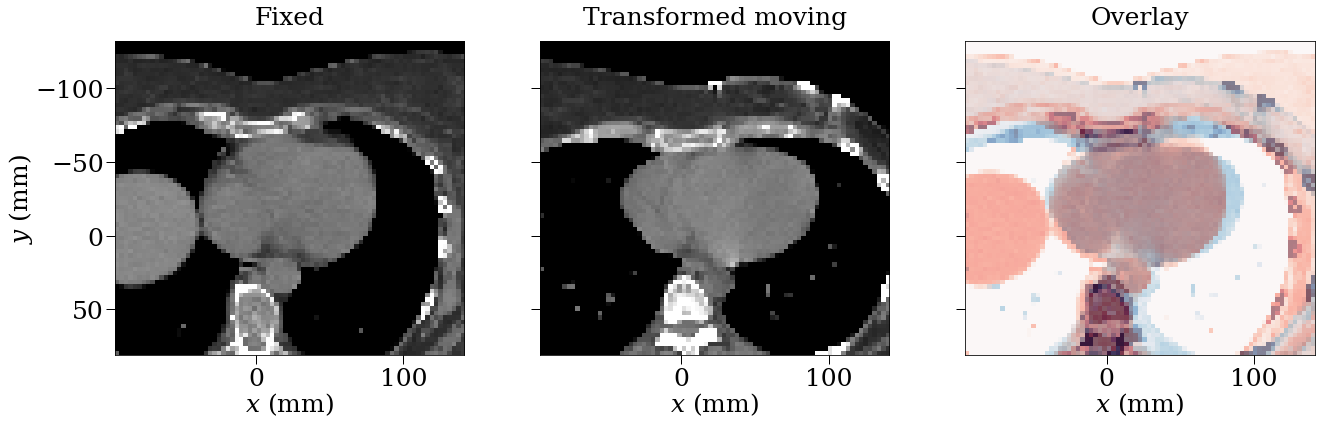

elastix: local (Heart) - bspline


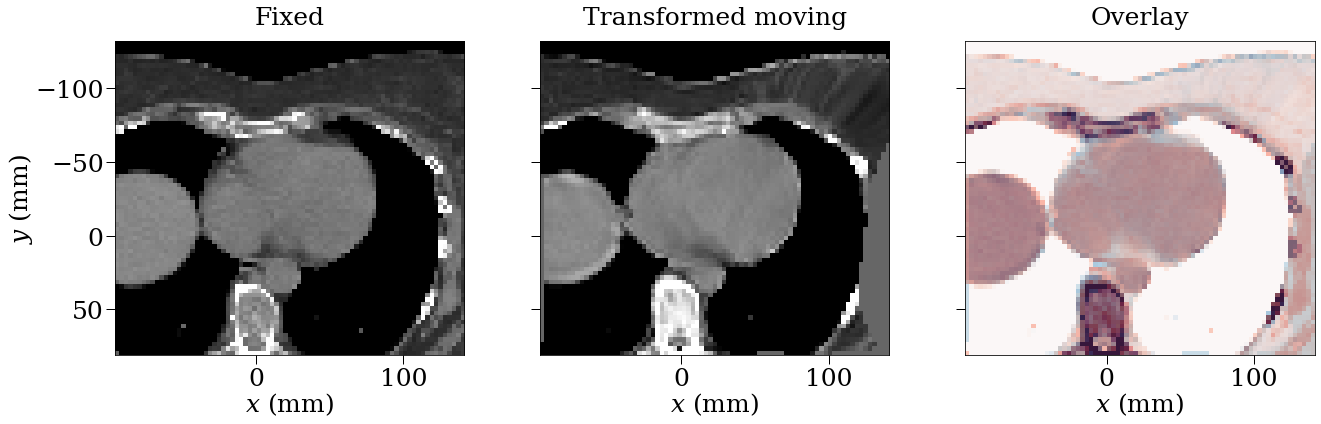

elastix: local (Ipsi_Lung) - initial_alignment


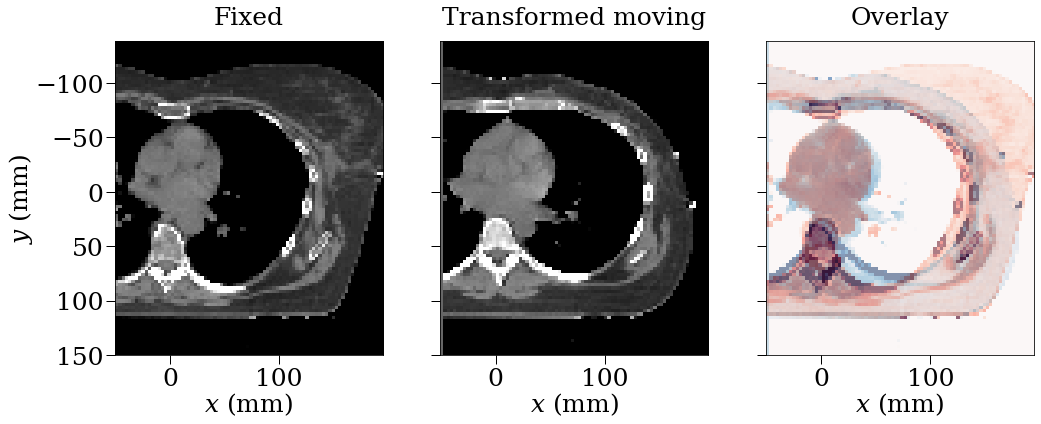

elastix: local (Ipsi_Lung) - bspline


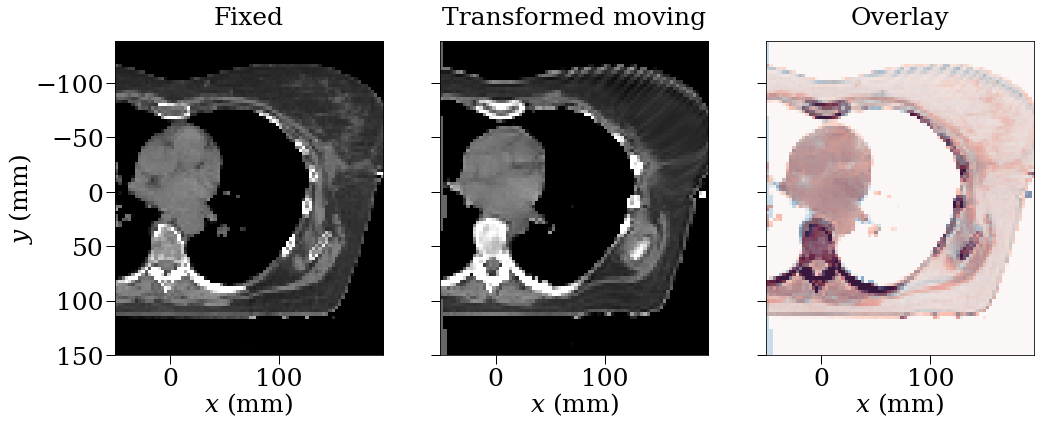

elastix: local (PTV_IMN_DVH) - initial_alignment


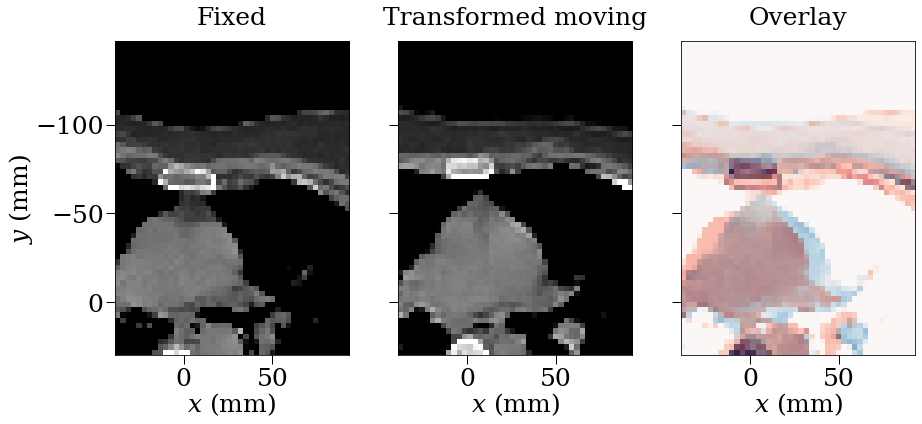

elastix: local (PTV_IMN_DVH) - bspline


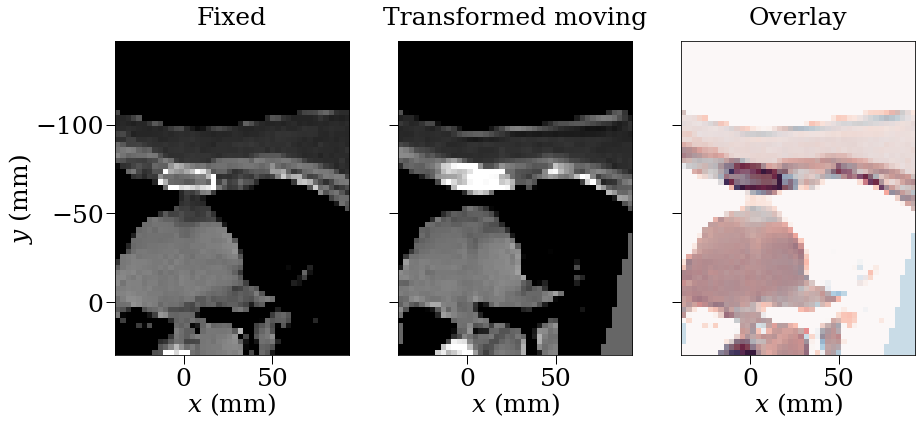

In [5]:
# Define atlas with which to compare.
atlas = atlases[0]
print(f"{test.id} vs {atlas.id}")

# Define ROI(s) for which to show results of local registration.
reg_roi_names = roi_names

# Show results at each step of registration.
sas = mas.get_sas(atlas.id)
for step in sas.get_auto_steps():
    for reg_roi_name in reg_roi_names:
        reg = sas.get_registration(step=step, roi_name=reg_roi_name)
        for reg_step in reg.steps:
            step_reg = f"{step} ({reg_roi_name})" if "local" == step else step
            print(f"{engine}: {step_reg} - {reg_step}")
            reg.view_result(reg_step)
        if "global" == step:
            break

## Segmentation results

The following compares the segmentations from the consensus result (multi-coloured), and the manual segmentation of the target (gold).

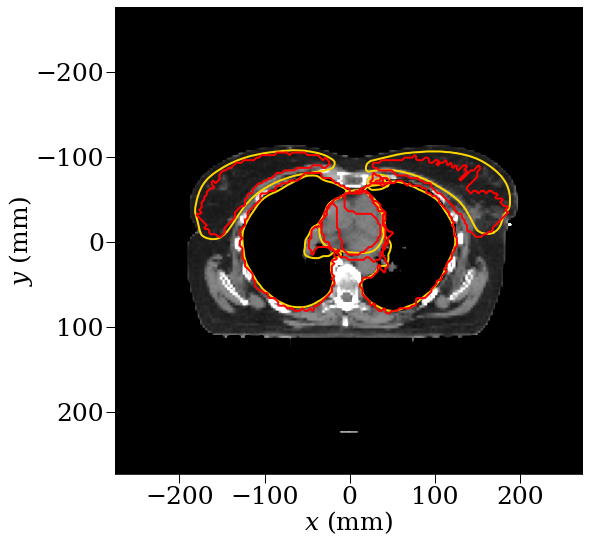

In [6]:
# Collect the atlas results in a single structure sets.
ss2_global = sum([mas.get_sas(idx).get_segmentation() for idx in mas.sass],
                 StructureSet())
for roi in ss2_global: roi.set_color("blue")

# Define structure set for the consensus result.
ss2_consensus = mas.get_consensus(consensus_type="staple").clone()
for roi in ss2_consensus: roi.set_color("red")

# Set colour for the manual segmentation of the test.
ss1_filtered = mas.get_sas().ss1_filtered or StructureSet()
for roi in ss1_filtered: roi.set_color("gold")

# Collect together all structure sets, and set the image to be the test image.
#rois = ss1_filtered + ss2_global + ss2_consensus
rois = ss1_filtered + ss2_consensus
# rois = ss1_filtered + ss2_global + ss2_consensus
rois.set_image(mas.im1)

# Display results
mas.im1.view(rois=rois, legend=False, init_view="x-y",
             figsize=8, zoom=1);

The following summarises Dice scores for final atlas-based segmentations compared with manual segmentation.

In [7]:
df1 = mas.get_comparison(atlas_ids_to_compare=True, consensus_types="staple",
                         reg_steps=-1, metrics="dice", id1=test.id, decimal_places=2)
print(f"Test patient: {test.id}\n")
print(df1.drop(columns=["id1", "strategy", "step", "reg_step"]));

# Optionally save results to file.
# df1.to_csv("multiatlas.csv", index=False)

Test patient: ANON02

              ROI  dice            id2
0        CTVn_IMN  0.42         ANON01
1       CTVp_4000  0.61         ANON01
2   Contra_Breast  0.78         ANON01
3     Contra_Lung  0.91         ANON01
4           Heart  0.92         ANON01
5       Ipsi_Lung  0.94         ANON01
6     PTV_IMN_DVH  0.55         ANON01
7        CTVn_IMN  0.42  ANON01_staple
8       CTVp_4000  0.61  ANON01_staple
9   Contra_Breast  0.78  ANON01_staple
10    Contra_Lung  0.91  ANON01_staple
11          Heart  0.92  ANON01_staple
12      Ipsi_Lung  0.94  ANON01_staple
13    PTV_IMN_DVH  0.55  ANON01_staple


## Create additional ROIs

The following creates a patient outline through intensity-based segmentation, then creates additional ROI through operations on the existing ROIs.

In [8]:
# Create the structure-set object to be written to output.
ss2_out = mas.get_consensus(consensus_type="staple").clone()
for roi in ss2_out.get_rois():
    roi.set_color(atlases[0].structure_set[roi.name].color)
# Add ROI for patient outlined.
ss2_out.add_roi(test.ct.get_foreground_roi(name="Skin"))
# Add ROI corresponding to "CTVp_4000" plus margin of 5mm,
# but at least 5 mm from "Skin" boundary.
ss2_out.add_roi((ss2_out["CTVp_4000"].resized(5)
                 * ss2_out["Skin"].resized(-5)).renamed("PTVp_4000"))
# Add ROI corresponding to "CTVn_IMN" plus margin of 5mm,
# but at least 5 mm from "Skin" boundary.
ss2_out.add_roi((ss2_out["CTVn_IMN"].resized(5)
                 * ss2_out["Skin"].resized(-5)).renamed("PTVn_LN_IMN"))
# Add ROI corresponding to "Ipsi_Lung" with "PTVn_LN_IMN" subtracted.
ss2_out.add_roi((ss2_out["Ipsi_Lung"]
                 - ss2_out["PTVn_LN_IMN"]).renamed("PTVn_LN_IMN_DVH"))

In [9]:
# Print list of ROI names.
ss2_out.get_roi_names()

['CTVn_IMN',
 'CTVp_4000',
 'Contra_Breast',
 'Contra_Lung',
 'Heart',
 'Ipsi_Lung',
 'PTV_IMN_DVH',
 'Skin',
 'PTVp_4000',
 'PTVn_LN_IMN',
 'PTVn_LN_IMN_DVH']

## Write data in DICOM format

The following writes the structure set, and the image to which it relates, in DICOM format.  The image needs to be written first, read back, and reassigned to the structure set before the latter is written, to ensure that UIDs are consistent.

In [10]:
# Define patient folder for output data.
patientdir = exportdir / test.id
# Set values for DICOM header.
header_extras = {
    "PatientName": test.id,
    "PatientID": test.id,
}

# Write image and structure set to the same folder,
# so that they can be imported by MatRad.
test.ct.write(outname=patientdir, header_extras=header_extras)
ss2_out.set_image(Image(patientdir))
ss2_out.write(outdir=patientdir, ext=".dcm", header_extras=header_extras)

Wrote dicom file(s) to directory: /Users/karl/codeshare/scikit-rt/examples/notebooks/export/ANON02
Wrote dicom file to directory: /Users/karl/codeshare/scikit-rt/examples/notebooks/export/ANON02


## Reading of DICOM data

The following demonstrates reading of the DICOM data.  The image is automatically associated with the structure set, and by default is underlaid when the structure set is viewed.

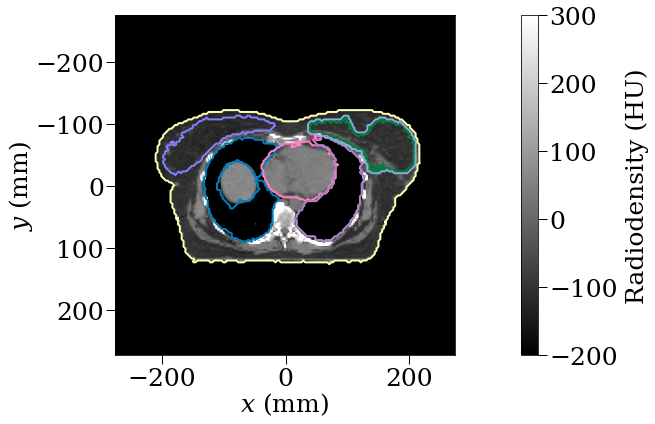

In [11]:
p = Patient(patientdir, unsorted_dicom=True)
assert 1 == len(p.get_structure_sets())
p.get_structure_sets()[0].view(title="", colorbar=True);